<a href="https://colab.research.google.com/github/sakuronohana/cas_datenanalyse/blob/master/Semesterarbeit/CAS_DA_SA_Payment_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img 
src="https://www.ffhs.ch/templates/ffhs/img/logo@2x.png" width="100"> 
###DaAn, Data Analysis, MAS/CAS Web4B 2018, ZH1, FS19, Dr. Tödtli Beat###

##*Semesterarbeit von Patrik Di Lena*##
#Betrugserkennung Zahlungsverkehr#



##Ziel##
Das Ziel dieser Semesterarbeit ist die Gegenüberstellung von Supervised und Unsupervised Lernverfahren mit eine neuronalen Netzwerk Algorthmus. Dabei kommt  ein nicht gelabelter und ein gelabelter Datensatz aus einem Betrugserkennungssystem zum Einsatz. 

##Aufgabenstellung##
###Erkennung von Betrugszahlungen###
Mittels Unsupervised Learning sollen Betrugszahlungen aus einem nicht gelabelten Datensatz erkannt und die Effiktivität des vorhandenen Fraud-Detection Systems geprüft werden.

###Betrugsanfällige Risikogruppen###
Mit Hilfe von Supervised Learning werden mögliche Risikogruppen ermittelt, welche im Visier von Betrügern stehen.  Auf Basis eines gelabelten Datensatzes  werden die Risikogruppen nach folgenden Merkmalen unterschieden:

*	Geschlecht
*	Alter
*	Zivilstand
*	Nationalität
*	Kontosaldo
*	Wohnort
*	Region

##Datensatz##
Die im Rahmen dieser Semesterarbeit verwendeten Daten entstammen, von ihrer Datenstruktur her, aus einem bereits eingesetzten nicht ML-basierten Betrugserkennungssystem. Die Datenwerte wurde zu Wahrung der datenschutzrechtlichen und bankengesetzlichen Aspekte mit Hilfe eines Python-Scripts künstlich erzeugt und beinhalten somit keine reale Zahlungs- oder Kunden-Informationen.   

Datenselektion:

- 20'800 synthetische Kunden (Vorname, Name, Strasse, Ort, Kanton, Sprachregion, Geschlecht, Alter, Zivilstand,  Nationalität, Kontonummer, Vertragsnummer, Rechtsform)

- 60'000 synthetische Zahlungen (Transaktionsid, ,Erstellungdatum/Zeit, Empfängerkonto, Empfängerbank, Empfängerland, Währung, Betrag, Valuta Datum)








#Erkennung von Betrugszahlungen# 

##Unsupervised Learning mit neuronalen Netzwerken##

###Importieren der ungelabelten Fraud-Zahlungsdaten###

In [26]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Laden der 600000 nicht gelabelten Transaktionsdaten 
trx_data_url = 'https://raw.githubusercontent.com/sakuronohana/cas_datenanalyse/master/Semesterarbeit/Dataset/trx_data_ol.csv'

trx_data_ol = pd.read_csv(trx_data_url, delimiter=';')
trx_data_ol.head()



,timestamp,paym_id,send_bc_nr,amount,rcv_bc_nr,rcv_bc_iban,rcv_bc_country,rcv_bc_code,rcv_iban,valuta_date,cust_vertrag_nr,cust_konto_nr,cust_vname,cust_nname,cust_plz,cust_ort,cust_kanton,cust_sprachregion,cust_auth_device
0,01.01.18 08:00,10000010,CHBANK71XXX,15368,JOBANK40XXX,JO02SCBL1260000000018525836101,Jordanien,JO,JO40002096331755419,01.01.18 08:00,76311,CH5300772672529640195,Martin,Bader,6020,Emmenbrücke,LU,de,mtan
1,01.01.18 08:00,10000011,CHBANK71XXX,89137,STBANK68XXX,ST23000200000289355710148,Sao Tome und Principe,ST,ST68002492808312214,01.01.18 20:00,69891,CH5300772670061796126,Margaretha,Fehr,9056,Gais,AR,de,ptan
2,01.01.18 08:01,10000012,CHBANK71XXX,87673,XKBANK43XXX,XK051301001002074155,Kosovo,XK,XK43002422391264290,02.01.18 08:01,78573,CH5300772500037725234,Daniel,Miéville,1253,Vandoeuvres,GE,fr,ptan
3,01.01.18 08:01,10000013,CHBANK71XXX,55941,RSBANK72XXX,RS35105008054113238018,Serbien,RS,RS72002873180573624,02.01.18 20:01,75443,CH5300772732508635138,Andrea,Iseni,6026,Rain,LU,de,mtan
4,01.01.18 08:02,10000014,CHBANK71XXX,88173,LIBANK48XXX,LI0308800000022875748,Liechtenstein,LI,LI48002899580343897,03.01.18 08:02,73167,CH5300772640237288398,Andrea,Pinana,6693,Broglio,TI,it,mtan


###Feature Engineering###

In [28]:
# Bestimmte Daten in das richtige Format konvertieren

# timestamp in Datums-und Zeitformat umwandeln
trx_data_ol.timestamp = pd.to_datetime(trx_data_ol['timestamp'])

#Suche des Datensatzes nach Null-Werten
trx_data_ol.isnull().values.sum()


0

**Visualisierung der Daten**

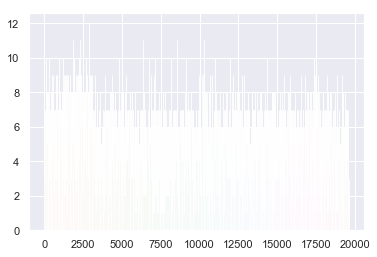

In [29]:
trx_data_count = trx_data_ol['cust_vertrag_nr'].value_counts()
sns.set(style='darkgrid')
sns.barplot(trx_data_count.index, trx_data_count.values, alpha=0.9)
plt.title('Kunden Verträge')
plt.show()

**Encoding kategorische Werte in nummerische Werte**

In [32]:
#Encoding Object Werte in Numeric Werte

#Ausfilterung der kategorischen Variablen mittels Datentyp
trx_data_ol_cat = trx_data_ol.select_dtypes(include=['object']).copy()

#Unwandlung der Werte Datentype Object in Catergory
trx_data_ol_cat = trx_data_ol_cat.astype('category')
trx_data_ol_cat.dtypes

send_bc_nr           category
rcv_bc_nr            category
rcv_bc_iban          category
rcv_bc_country       category
rcv_bc_code          category
rcv_iban             category
valuta_date          category
cust_konto_nr        category
cust_vname           category
cust_nname           category
cust_ort             category
cust_kanton          category
cust_sprachregion    category
cust_auth_device     category
dtype: object

In [0]:
# Categorical boolean mask
categorical_feature_mask = trx_data_ol.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = trx_data_ol.columns[categorical_feature_mask].tolist()

# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()

# apply le on categorical feature columns
trx_data_ol[categorical_cols] = trx_data_ol[categorical_cols].apply(lambda col: le.fit_transform(col))
trx_data_ol[categorical_cols].head(10)


,timestamp,send_bc_nr,rcv_bc_nr,rcv_bc_iban,rcv_bc_country,rcv_bc_code,rcv_iban,valuta_date,cust_konto_nr,cust_vname,cust_nname,cust_ort,cust_kanton,cust_sprachregion,cust_auth_device
0,0,0,36,36,29,36,28548,2,13943,261,164,217,4,0,0
1,0,0,67,67,56,67,53597,3,13891,247,1239,251,1,0,1
2,1,0,74,74,32,74,59059,1974,10414,84,2629,667,3,1,1
3,1,0,60,60,60,60,48335,1975,15222,18,1943,532,4,0,0
4,2,0,41,41,37,41,33136,3945,13286,18,2977,86,5,2,0
5,2,0,5,5,5,5,4390,3946,3589,313,1880,385,4,0,1
6,3,0,4,4,2,4,3287,5917,5494,401,1009,594,4,0,0
7,3,0,47,47,46,47,37623,5918,10647,277,2058,229,2,1,1
8,4,0,63,63,58,63,50252,7890,19990,128,2229,678,5,2,1
9,4,0,52,52,47,52,41360,7891,4624,396,2736,217,4,0,1


#Ermittlung potenzieller Kundenrisikogruppen# 
##Supervised Learning mit neuronalen Netzwerken##


In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Laden der 600000 Transaktionsdaten 
trx_data_url = 'https://raw.githubusercontent.com/sakuronohana/cas_datenanalyse/master/Semesterarbeit/Dataset/trx_data_ml.csv'

trx_data_ml = pd.read_csv(trx_data_url, delimiter=';')
trx_data_ml.head()


In [0]:
trx_data_ol.nunique()

In [0]:
trx_data.fraud_id.map(lambda x:1 if x>=1 else 0).mean()

##Datensatz analysieren##

##Tipp: Plotting Learning Curves - Scikit !!!!

In [0]:
# Visualisierung der Nummerischen Daten in dem Datensatz
trx_data.hist(bins=50, figsize=(20,15))
plt.show()

In [0]:
# Suche nach den Korrelationen - Teil 1
corr_matrix = trx_data.corr()
print ('Korrelation zu Payment ID','\n',corr_matrix['paym_id'].sort_values(ascending=False))
print ('Korrelation zu Zahlungssumme','\n',corr_matrix['amount'].sort_values(ascending=False))
print ('Korrelation zu Kundenvertrag','\n',corr_matrix['cust_vertrag_nr'].sort_values(ascending=False))
print ('Korrelation zu Betrugsid','\n',corr_matrix['fraud_id'].sort_values(ascending=False))

In [0]:
# Bereinigung der Daten
pd.to_datetime(trx_data['timestamp'])
pd.to_datetime(trx_data['valuta_date'])
np.where(np.isnan(trx_data))

In [0]:
# Datensatz in Trainings(80%)- und Testdatenset (20%) teilen
from sklearn.model_selection import train_test_split
train_trx_data, test_trx_data = train_test_split(trx_data, test_size=0.2, random_state=42) 
train_trx_data.count(), test_trx_data.count()

In [0]:
# Dimensionsreduktion mit PCA
from sklearn.decomposition import PCA # Import der PCA Funktion von Scikit Learn
from sklearn import preprocessing # Die Preprocessing Funktion hilft uns die Daten zu skalieren bevor sie mit PCA verwendet werden.